# Supply Chain Data Analytics

Analyzing and Forcasting Supermarket Sales

Stan Brouwer (Vrije Universiteit)  
Liz Chan (Master TSCM)  
Maaike Lamberst (Supply Chain Data analysis)  
Niek Schroor (Group 10)  
December 5, 2024

Introduction

We analyze, forecast and interpret the [Superstore sales](https://public.tableau.com/app/sample-data/sample_-_superstore.xls) provided by [Tableau](https://public.tableau.com/app/learn/sample-data) using different statistical and machine learning methods.

We describe our work in the PDF version. However, we would like to recommend reading our quarto manuscript *here* as it contains the **relevant** R code in the Article Notebook.

## 1 Data Pre-processing

The superstore data set we selected is of high quality. Thus we do the required data pre-processing, but included the hypothetical steps we would take were our data of lower quality to communicate our understanding of the data pre-processing process.

We took the following pre-processing steps:

In [ ]:
# Clear workspace
rm(list = ls())
# Function to load (and install if necessary) dependencies
install_and_load <- function(packages) {
  install.packages(setdiff(packages, rownames(installed.packages())), dependencies = TRUE)
  invisible(lapply(packages, require, character.only = TRUE))
}
install_and_load(c("tidyverse", "readxl", "ggplot2", "lubridate", "stats", "Amelia","forecast", "tseries", "plotly", "stringr", "knitr"))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: Amelia

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.8.3, built: 2024-11-07)
## Copyright (C) 2005-2024 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: tseries

Loading required package: plotly

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: knitr

-   Improved column names by removing whitespaces
-   Removed the <code>Row_ID</code> column as it can be inferred by it’s index
-   Removed all columns with a single unique value, as storing these would be [redundant](https://few.vu.nl/~molenaar/courses/StatR/chapters/B-06-raw_data.html)
-   Ensured machine-readable date formats in yyyy-mm-dd as these usually differ per locale.
-   Ensured proper decimal separators
-   calculated the number of missing values (both NA and empty string ““) per column.

In [ ]:
# Load the data
suppressWarnings({data <- read_excel("data/sample_-_superstore.xls")}) # The Postal code column is stored as 'text' but coerced to numeric, causing warnings which we suppress

# Improve column names (replace " "with "_")
colnames(data) <- str_replace_all(colnames(data), " ", "_")

# Remove the 'Row_ID' column as it can be inferred by it's index
data <- subset(data, select = -`Row_ID`)

# Remove all columns that have only one unique value, as storing these would be redundant
data <- data[, sapply(data, function(col) length(unique(col)) > 1)]

# Ensure a machine-readable date format as these are usually horrible in excel files
data$Order_Date <- as.Date(data$Order_Date, format = "%Y-%m-%d")
data$Ship_Date <- as.Date(data$Ship_Date, format = "%Y-%m-%d")

# The readxl package by default uses the correct decimal separator (as opposed to base R)

# Calculate the number of missing values per column.
# The sample dates are likely in Unix time, and when these are converted to R date objects they are stored as Date objects (which are represented by 'double' datatypes). Comparing these dates to characters (empty strings) results in NA values. Thus we only check date values for NA. As Date objects are stored as doubles within R (amount of days since 1970-01-01), we can't check numeric columns for " " either. We thus only check character columns for " ".
missing_values <- sapply(data, function(col) {
  if (inherits(col, "Date")) {
    sum(is.na(col))
  } else if (is.character(col)) {
    sum(is.na(col) | col == "")
  } else {
    sum(is.na(col))
  }
})

if (sum(missing_values) == 0) {
  print("No missing values")
}

[1] "No missing values"

We also ran some descriptive statistics to check unlikely or impossible values, outliers, means, etc.

In [ ]:
# Select only numerical columns
numerical_data <- data %>% select_if(is.numeric)

# Apply sapply to calculate descriptive statistics for each numeric column
descriptive_stats <- sapply(numerical_data, function(col) {
  # Remove NA values
  col <- na.omit(col)
  
  # Calculate basic statistics
  min_val <- min(col)
  max_val <- max(col)
  mean_val <- mean(col)
  median_val <- median(col)
  
  # 95% Confidence Interval (assuming normal distribution)
  se <- sd(col) / sqrt(length(col))  # Standard error
  ci_lower <- mean_val - 1.96 * se  # Lower bound of 95% CI
  ci_upper <- mean_val + 1.96 * se  # Upper bound of 95% CI
  
  # Calculate outliers (using 1.5 * IQR rule)
  Q1 <- quantile(col, 0.25)
  Q3 <- quantile(col, 0.75)
  IQR <- Q3 - Q1
  outliers <- sum(col < (Q1 - 1.5 * IQR) | col > (Q3 + 1.5 * IQR))  # Number of outliers
  
  # Return the statistics as a named vector
  return(c(Min = min_val, 
           Mean = mean_val, 
           Max = max_val, 
           Median = median_val, 
           `95% CI Lower` = ci_lower, 
           `95% CI Upper` = ci_upper, 
           Outliers = outliers))
})
head(data,5)

# A tibble: 5 × 19
  Order_ID     Order_Date Ship_Date  Ship_Mode Customer_ID Customer_Name Segment
  <chr>        <date>     <date>     <chr>     <chr>       <chr>         <chr>  
1 CA-2016-152… 2016-11-08 2016-11-11 Second C… CG-12520    Claire Gute   Consum…
2 CA-2016-152… 2016-11-08 2016-11-11 Second C… CG-12520    Claire Gute   Consum…
3 CA-2016-138… 2016-06-12 2016-06-16 Second C… DV-13045    Darrin Van H… Corpor…
4 US-2015-108… 2015-10-11 2015-10-18 Standard… SO-20335    Sean O'Donne… Consum…
5 US-2015-108… 2015-10-11 2015-10-18 Standard… SO-20335    Sean O'Donne… Consum…
# ℹ 12 more variables: City <chr>, State <chr>, Postal_Code <dbl>,
#   Region <chr>, Product_ID <chr>, Category <chr>, `Sub-Category` <chr>,
#   Product_Name <chr>, Sales <dbl>, Quantity <dbl>, Discount <dbl>,
#   Profit <dbl>

There is some more processing to do, such as removing outliers. However, by doing so we impose our own assumptions on the data (possibly the outliers are actual sales?). We will visualize and qualitatively evaluate the data first, and then decide what other processing steps to take.

In [ ]:
# Display the first 5 rows of the data in a nice table with kable
kable(head(data,5), caption = "First 5 Rows of the Data", format = "pipe")

## 2 Section

This is a simple placeholder for the manuscript’s main document ([**knuth84?**](#ref-knuth84)).

In [ ]:
1 + 1

[1] 2

## 3 Introduction

In [ ]:
eruptions <- c(1492, 1585, 1646, 1677, 1712, 1949, 1971, 2021)
n_eruptions <- length(eruptions)

In [ ]:
par(mar = c(3, 1, 1, 1) + 0.1)
plot(eruptions, rep(0, n_eruptions), 
  pch = "|", axes = FALSE)
axis(1)
box()

In [ ]:
avg_years_between_eruptions <- mean(diff(eruptions[-n_eruptions]))
avg_years_between_eruptions

[1] 79.83333

Based on data up to and including 1971, eruptions on La Palma happen every 79.8 years on average.

Studies of the magma systems feeding the volcano, such as Marrero et al. ([2019](#ref-marrero2019)), have proposed that there are two main magma reservoirs feeding the Cumbre Vieja volcano; one in the mantle (30-40km depth) which charges and in turn feeds a shallower crustal reservoir (10-20km depth).

Eight eruptions have been recorded since the late 1400s (<a href="#fig-timeline" class="quarto-xref">Figure 1</a>).

Data and methods are discussed in <a href="#sec-data-methods" class="quarto-xref">Section 4</a>.

Let $x$ denote the number of eruptions in a year. Then, $x$ can be modeled by a Poisson distribution

<span id="eq-poisson">$$
p(x) = \frac{e^{-\lambda} \lambda^{x}}{x !}
 \qquad(1)$$</span>

where $\lambda$ is the rate of eruptions per year. Using <a href="#eq-poisson" class="quarto-xref">Equation 1</a>, the probability of an eruption in the next $t$ years can be calculated.

| Name                | Year |
|---------------------|------|
| Current             | 2021 |
| Teneguía            | 1971 |
| Nambroque           | 1949 |
| El Charco           | 1712 |
| Volcán San Antonio  | 1677 |
| Volcán San Martin   | 1646 |
| Tajuya near El Paso | 1585 |
| Montaña Quemada     | 1492 |

Table 1: Recent historic eruptions on La Palma

<a href="#tbl-history" class="quarto-xref">Table 1</a> summarises the eruptions recorded since the colonization of the islands by Europeans in the late 1400s.

<figure id="fig-map">
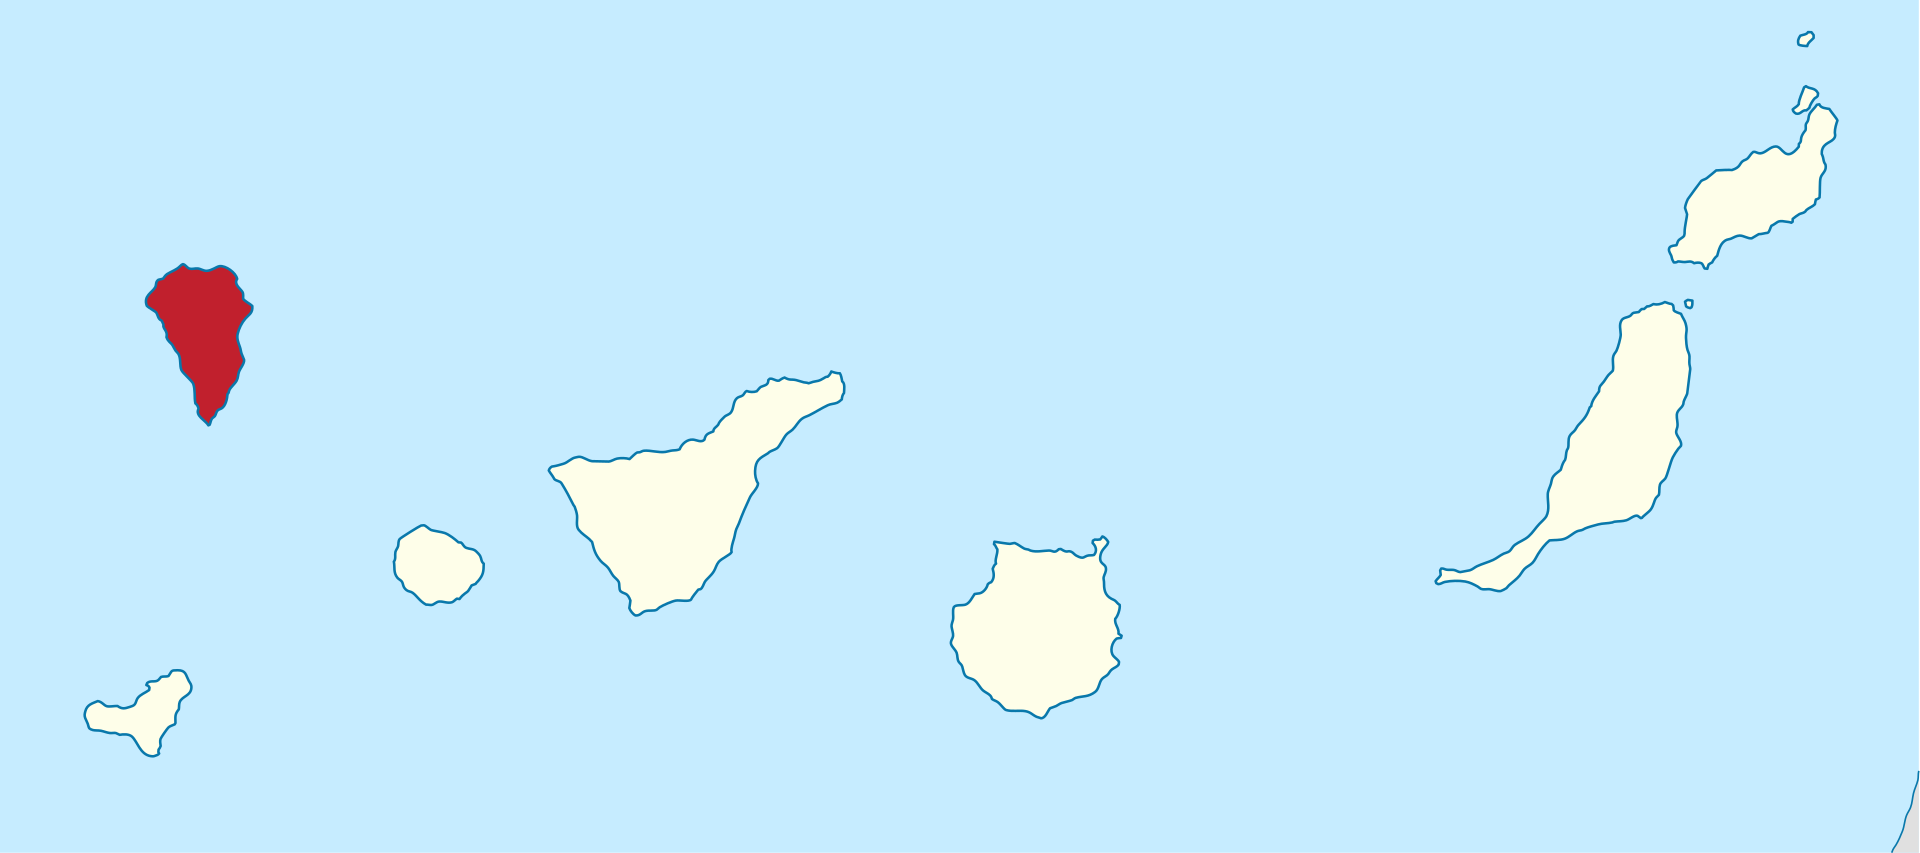
<figcaption>Figure 2: Map of La Palma</figcaption>
</figure>

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands (<a href="#fig-map" class="quarto-xref">Figure 2</a>).

## 4 Data & Methods

## 5 Conclusion

## References

Marrero, José, Alicia García, Manuel Berrocoso, Ángeles Llinares, Antonio Rodríguez-Losada, and R. Ortiz. 2019. “Strategies for the Development of Volcanic Hazard Maps in Monogenetic Volcanic Fields: The Example of La Palma (Canary Islands).” *Journal of Applied Volcanology* 8 (July). <https://doi.org/10.1186/s13617-019-0085-5>.